<a href="https://colab.research.google.com/github/novoselov-ie/Cat_Dog_classification/blob/main/Cat_and_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для решения задачи классификации планирую использовать предобученную модель на архитектуре ResNet34

Задача - разработать модель машинного обучения для определения класса изображений между кошками и собаками.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from PIL import Image
import matplotlib.pyplot as plt

**Загрузка данных: набор данных Cats vs Dogs**

In [ ]:
import os
import numpy as np

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

Отфильтруем поврежденные изображения

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1578 images.


In [ ]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
from pathlib import Path
data_path = Path("")
image_path = data_path / "PetImages"

walk_through_dir(image_path)

There are 2 directories and 0 images in 'PetImages'.
There are 0 directories and 11749 images in 'PetImages\Cat'.
There are 0 directories and 11675 images in 'PetImages\Dog'.


Random image path: PetImages\Dog\7609.jpg
Image class: Dog
Image height: 262
Image width: 300


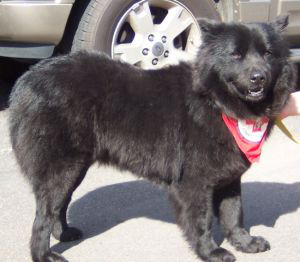

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Затем создадим код для отображения наших классов. И код для обработки наших  изображений

In [ ]:
def plot_transformed_images(image_paths, transform, n=2, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

Используем трансформацию для нашего датасета

In [ ]:
img_dimensions = 224
img_transforms = transforms.Compose([
    transforms.Resize((img_dimensions, img_dimensions)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


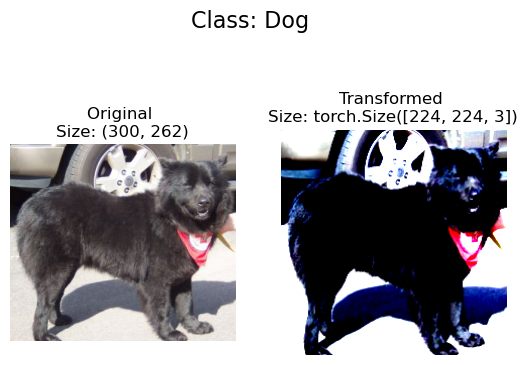

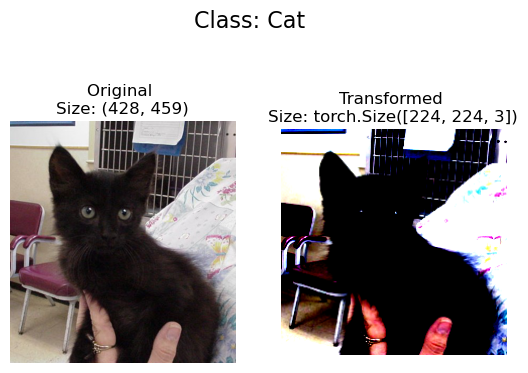

In [ ]:
plot_transformed_images(image_path_list,
                        transform=img_transforms,
                        n=2)

**Загрузка данных в датасет используя datasets.ImageFolder и random_split**

In [ ]:
import math

root_dir = "PetImages"
# Создание ImageFolder датасета
dataset = datasets.ImageFolder(root=root_dir, transform=img_transforms)

# Определение размеров train, valid и test наборов
total_size = len(dataset)
train_size = math.ceil(0.7 * total_size)
test_size = math.ceil(0.15 * total_size)
val_size = total_size - train_size - test_size

# Разделение данных на train, valid и test наборы
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
class_names = dataset.classes
class_names

['Cat', 'Dog']

**Загрузка изображений в DataLoader**

In [ ]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
img, label = next(iter(train_loader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [ ]:
print(f'Num training images: {len(train_loader.dataset)}')
print(f'Num validation images: {len(val_loader.dataset)}')
print(f'Num test images: {len(test_loader.dataset)}')

Num training images: 16396
Num validation images: 3512
Num test images: 3514




---
**Загрузка модели, предварительно обученную в ImageNet, с помощью PyTorch Hub.**

In [ ]:
model_resnet34 = torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/main" to C:\Users\user/.cache\torch\hub\main.zip
C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:08<00:00, 9.79MB/s]


Поскольку мы проводим трансферное обучение, мы хотим заморозить все параметры, кроме слоев BatchNorm, поскольку здесь они обучаются по среднему и стандартному отклонению ImageNet, и мы можем потерять некоторый сигнал.

In [ ]:
for name, param in model_resnet34.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

Затем заменяем классификатор, чтобы мы могли делать прогнозы по нашему набору данных, а не по 1000 классам из ImageNet, на которых обучалась модель.

In [ ]:
num_classes = 2

model_resnet34.fc = nn.Sequential(nn.Linear(model_resnet34.fc.in_features,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))

## Функции для обучения и загрузки данных

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

### Обучение модели

In [ ]:
epochs = 10
model_resnet34.to(device)
optimizer = optim.Adam(model_resnet34.parameters(), lr=0.001)
train(model_resnet34, optimizer, torch.nn.CrossEntropyLoss(), train_loader, val_loader, epochs=epochs, device=device)

Epoch: 0, Training Loss: 0.0701, Validation Loss: 0.0270, accuracy = 0.9909


In [ ]:
torch.save(model_resnet34.state_dict(), "./model_resnet34.pth")

### Тестирование модели

In [ ]:
import random

# Установка seed для воспроизводимости
random.seed(42)

# Получение случайных элементов из test_loader
test_samples = []
test_labels = []
for batch in test_loader:
    batch_samples, batch_labels = batch
    batch_size = batch_samples.size(0)
    rand_idx = random.randint(0, batch_size - 1)
    test_samples.append(batch_samples[rand_idx])
    test_labels.append(batch_labels[rand_idx])

# Вывод информации о первом тестовом образце и метке
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 0 (Cat)


In [ ]:
def make_predictions(model, data_loader):
    predictions = []
    model.eval()
    with torch.inference_mode():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

In [ ]:
# Получение предсказаний для тестового набора
predictions = make_predictions(model_resnet34, test_loader)

In [ ]:
# Получение истинных меток и предсказанных меток
true_labels = torch.tensor([label for _, label in test_dataset])
predicted_labels = torch.tensor(predictions)

## Оценка производительности модели

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Конвертация меток из тензоров PyTorch в обычные массивы NumPy
true_labels = true_labels.numpy()
predicted_labels = predicted_labels.numpy()

# Вычисление метрик
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.9886169607285145
Precision: 0.983323749281196
Recall: 0.9936083672283557
F1 Score: 0.9884393063583815
Confusion Matrix:
[[1764   29]
 [  11 1710]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


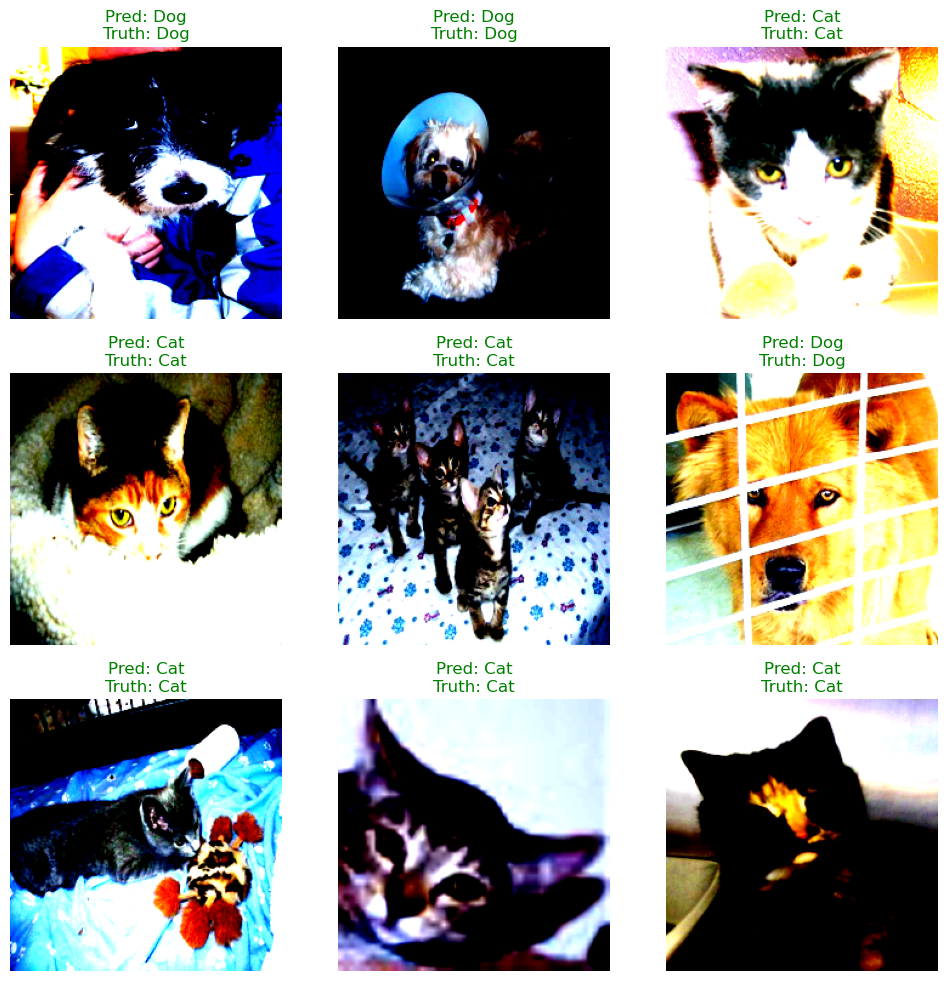

In [ ]:
# Вывод 9 изображений и их предсказанных меток
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image, label = test_dataset[i]
    image = image.permute(1, 2, 0)
    plt.imshow(image.numpy())
    pred_label = class_names[predictions[i]]
    truth_label = class_names[label]
    if pred_label == truth_label:
        plt.title(f'Pred: {pred_label}\nTruth: {truth_label}', color='g')
    else:
        plt.title(f'Pred: {pred_label}\nTruth: {truth_label}', color='r')
    plt.axis('off')
plt.show()

**Отображение НЕПРАВИЛЬНЫХ предсказаний**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


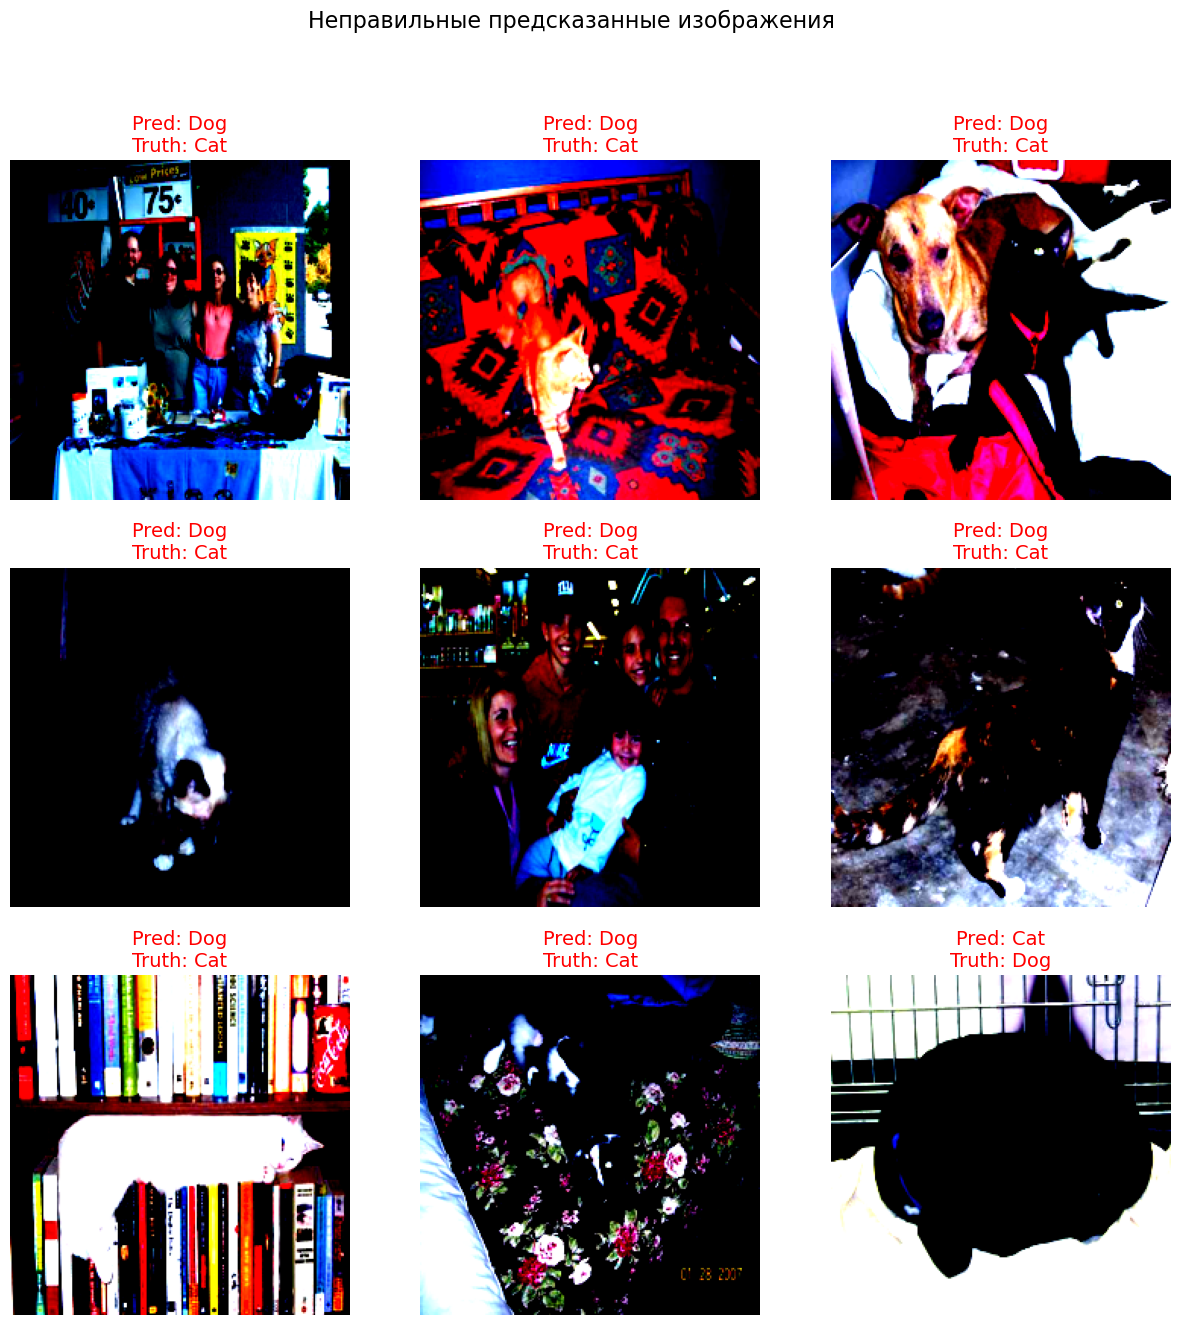

In [ ]:
# Вывод неправильных предсказаний
plt.figure(figsize=(15, 15))
plt.suptitle('Неправильные предсказанные изображения', fontsize=16)

incorrect_samples = []

for i, (pred, target) in enumerate(zip(predicted_labels, true_labels)):
    if pred != target:
        incorrect_samples.append(i)

nrows = ncols = min(len(incorrect_samples), 9)
for i, sample_idx in enumerate(incorrect_samples[:9]):
    image, label = test_dataset[sample_idx]
    image = image.permute(1, 2, 0).numpy()

    plt.subplot(3, 3, i + 1)
    plt.imshow(image)

    pred_label = class_names[predicted_labels[sample_idx]]
    truth_label = class_names[true_labels[sample_idx]]

    plt.title(f'Pred: {pred_label}\nTruth: {truth_label}', color='r', fontsize=14)
    plt.axis('off')

plt.show()

In [ ]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

Матрица ошибок

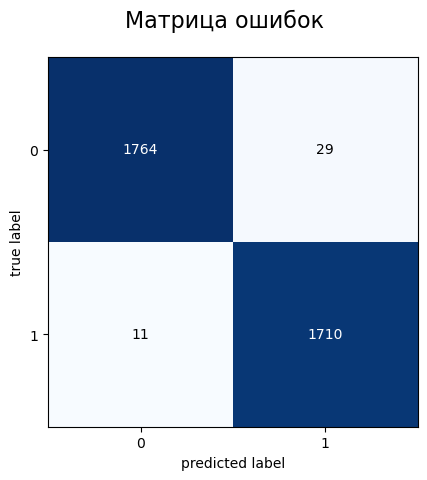

In [ ]:
# Обновление матрицы путаницы с предсказанными и истинными метками

fig, ax = plot_confusion_matrix(conf_mat=conf_matrix)
plt.suptitle('Матрица ошибок', fontsize=16)
plt.show()